# Задание 3. Статистика CUSUM

Для начала возьмём данные и построим по ним график, чтобы увидеть общую картину.

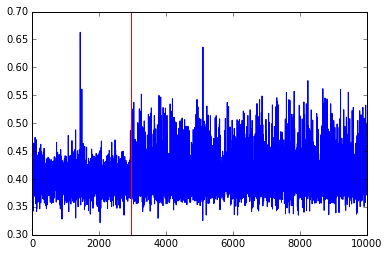

In [1]:
%matplotlib inline

import numpy
from matplotlib import mlab
from matplotlib import pyplot

data = list(map(float, open('ts1.txt')))

pyplot.plot(data)
pyplot.axvline(x=2959, color='r')
pyplot.show()

Поскольку ответ на задачу известен (2959, и это неплохо видно на графике), попробуем узнать что-нибудь о характере распределений до и после разладки. После построения видно, что первая часть весьма напоминает нормальное распределение ($N(a_1, b_1)$, параметры которого мы можем довольно точно найти, так как метод моментов даёт оптимальную оценку), после разладки же распределение становится несимметричным. Чтобы увидеть "перекошенность" правого бока подробнее, построим разность старого нормального распределения и нового.

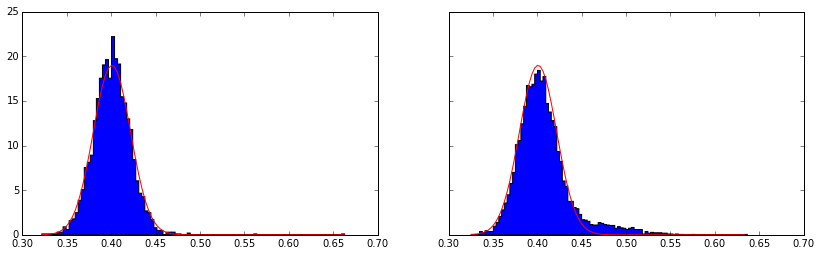

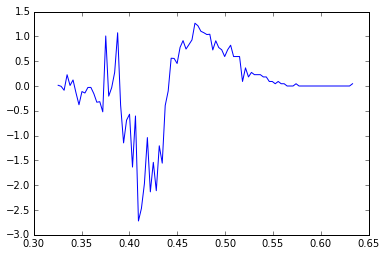

In [2]:
before, after = numpy.array(data[:2959]), numpy.array(data[2959:])
a_1, b_1 = numpy.mean(before), numpy.std(before)

fig, (ax1, ax2) = pyplot.subplots(1, 2, sharex=True, sharey=True)
fig.set_figwidth(14)
_, bins, _ = ax1.hist(before, 100, normed=1, histtype='stepfilled')
ax1.plot(bins, mlab.normpdf(bins, a_1, b_1), color='r')

after_hist, bins, _ = ax2.hist(after, 100, normed=1, histtype='stepfilled')
bins = bins[:-1]
ax2.plot(bins, mlab.normpdf(bins, a_1, b_1), color='r')
pyplot.show()

pyplot.plot(bins, after_hist - mlab.normpdf(bins, a_1, b_1))
pyplot.show()

Несмотря на нерегулярное поведение в левой части графика, по выраженному пику и характеру убывания можно предположить, что к нормальному распределению оказалось "примешано" другое нормальное, то есть после разладки
$$ \xi_k \overset{d}= b \cdot N(a_1, b_1) + (1 - b) \cdot N(a_2, b_2) $$
где $b \sim Bern(p)$ и все случайные величины независимы. Попробуем подобрать параметры $a_2, b_2, p$, чтобы проверить нашу гипотезу. Чтобы упростить себе работу можно воспользоваться методом моментов и решить появляющиеся уравенения численно.
$$ \overline{X} = E\xi_k = p \cdot a_1 + (1 - p) \cdot a_2 $$
$$ \overline{X^2} = E\xi_k^2 = p \cdot (a_1^2 + b_1^2) + (1 - p) \cdot (a_2^2 + b_2^2) $$
$$ \overline{X^3} = E\xi_k^3 = p \cdot (a_1^3 + 3 a_1 b_1^2) + (1 - p) \cdot (a_2^3 + 3 a_1 b_2^2) $$

/usr/lib/python3.5/site-packages/scipy/optimize/minpack.py:236: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


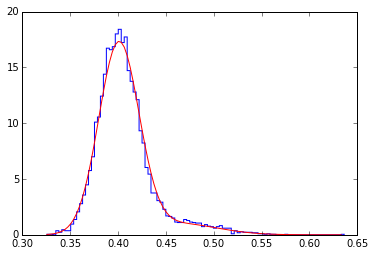

0.895733426611 0.462149031764 0.0411779726809


In [3]:
import functools
import scipy.optimize
import scipy.stats

def moment(a, b, k):
    return scipy.stats.norm.moment(k, loc=a, scale=b)
    
def F(a, b, r, x):
    p, c, d = x[0], x[1], x[2]
    return [p * moment(a, b, k) + (1 - p) * moment(c, d, k) - r[k - 1]
            for k in [1, 2, 3]]
            
r = [numpy.mean(after), numpy.mean(after ** 2), numpy.mean(after ** 3)]
f = functools.partial(F, a_1, b_1, r)
p, a_2, b_2 = scipy.optimize.fsolve(f, [0.9, 0.5, 0.05])

def f_pdf(x):
    return scipy.stats.norm.pdf(x, loc=a_1, scale=b_1)

def g_pdf(x):
    return f_pdf(x) * p + scipy.stats.norm.pdf(x, loc=a_2, scale=b_2) * (1 - p)

pyplot.hist(after, 100, normed=1, histtype='step', color='b')
pyplot.plot(bins, [g_pdf(x) for x in bins], color='r')
pyplot.show()

print(p, a_2, b_2)

Несмотря на замечания о плохой сходимости, получаем довольно правдоподобную картину. Теперь, собственно, посчитаем статистику CUSUM, чтобы определить момент разладки. На графике хорошо видно момент разладки, однако, чтобы работал метод с моментом остановки проведем небольшое экспоненциальное сглаживание и отбросим сильно выбивающиеся значения.

7 values filtered out
theta_1 = 2964


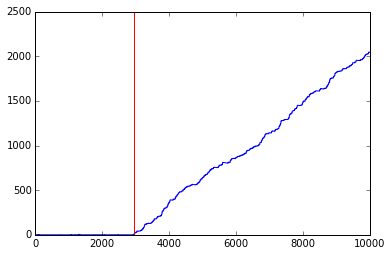

0.38067263508476495
theta_2 = 2959


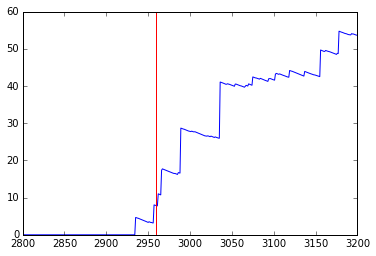

In [4]:
def smooth(data, alpha, threshold):
    value = 0
    filtered = 0
    for i, x in enumerate(data):
        value = value * alpha + (1 - alpha) * x
        if abs(value) < threshold:
            yield i, value
        else:
            filtered += 1
    print('%d values filtered out' % filtered)

S, S_idx, S_values = 0, list(), list()
critical, theta_1 = 10, -1
for i, x in smooth(data, alpha=0.05, threshold=0.55):
    S = max(0, S + numpy.log(g_pdf(x) / f_pdf(x)))
    S_values.append(S)
    S_idx.append(i)
    if S >= critical and theta_1 < 0:
        theta_1 = i
print('theta_1 = %d' % theta_1)

pyplot.plot(S_values)
pyplot.axvline(x=theta_1, color='r')
pyplot.show()

critical, theta_2 = 5, -1
for i, S in reversed(list(zip(S_idx, S_values))):
    if S < critical and theta_2 < 0:
        print(x)
        theta_2 = i + 1  # next value will be OK
print('theta_2 = %d' % theta_2)

pyplot.plot(range(2800, 3200), S_values[2800:3200])
pyplot.axvline(x=theta_2, color='r')
pyplot.show()

Ошибка получилась всего в 5 измерений. Ясно, что её вносит значение $\theta$, взятое достаточно большим, чтобы не учитывать флуктуации, происходившие до разладки. Если идти с конца процесса и искать первое значение с достаточно маленькой статистикой, можно приблизиться с ответу еще сильнее, так как у второго распределения меньше флуктуаций в меньшую сторону.

Перейдем теперь к данным с неизвестным ответом. Начальный план будет действий примерно тем же.

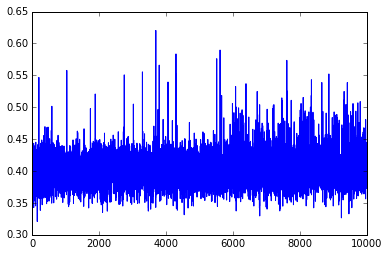

In [5]:
data = list(map(float, open('ts2.txt')))

pyplot.plot(data)
pyplot.show()

Второй датасет получился немного менее очевидным, однако "на глаз" кажется, что разладка произошла где-то в районе 6000-ного измерения. Попробуем проанализировать распределения по старой схеме. Для начала возьмем первые и последние 2000 измерений и посмотрим, какие там были распределения. 

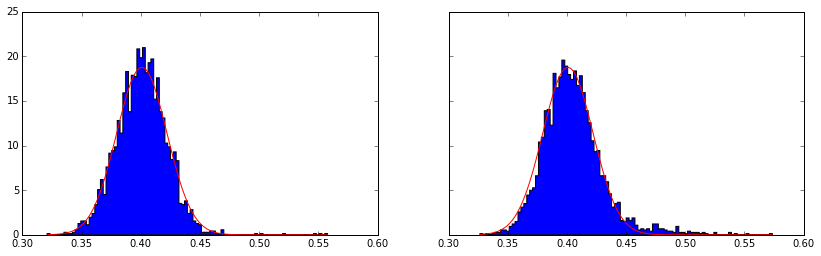

In [6]:
before, after = numpy.array(data[:3000]), numpy.array(data[-3000:])
a_1, b_1 = numpy.mean(before), numpy.std(before)

fig, (ax1, ax2) = pyplot.subplots(1, 2, sharex=True, sharey=True)
fig.set_figwidth(14)
_, bins, _ = ax1.hist(before, 100, normed=1, histtype='stepfilled')
ax1.plot(bins, mlab.normpdf(bins, a_1, b_1), color='r')

_, bins, _ = ax2.hist(after, 100, normed=1, histtype='stepfilled')
ax2.plot(bins, mlab.normpdf(bins, a_1, b_1), color='r')
pyplot.show()

Ситуация похожая, поэтому есть надежда приблизить распредения нормальными.

/usr/lib/python3.5/site-packages/scipy/optimize/minpack.py:236: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


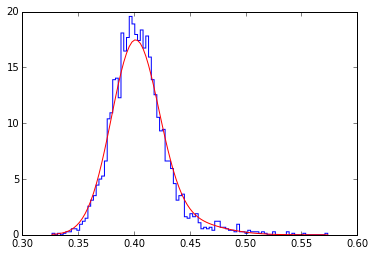

0.903095507338 0.442184644429 0.0319561674142


In [7]:
def F(a, b, r, x):
    p, c, d = x[0], x[1], x[2]
    return [p * moment(a, b, k) + (1 - p) * moment(c, d, k) - r[k - 1]
            for k in [1, 2, 3]]
            
r = [numpy.mean(after), numpy.mean(after ** 2), numpy.mean(after ** 3)]
f = functools.partial(F, a_1, b_1, r)
p, a_2, b_2 = scipy.optimize.fsolve(f, [0.9, 0.5, 0.05])

def f_pdf(x):
    return scipy.stats.norm.pdf(x, loc=a_1, scale=b_1)

def g_pdf(x):
    return f_pdf(x) * p + scipy.stats.norm.pdf(x, loc=a_2, scale=b_2) * (1 - p)

pyplot.hist(after, 100, normed=1, histtype='step', color='b')
pyplot.plot(bins, [g_pdf(x) for x in bins], color='r')
pyplot.show()

print(p, a_2, b_2)

Кажется, что получилось неплохо. Перейдем к вычислению статистики.

7 values filtered out
theta_1 = 6079


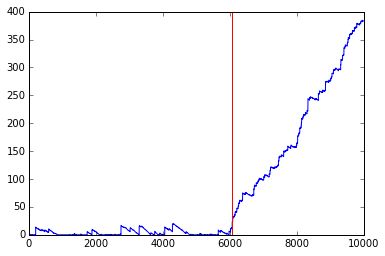

theta_2 = 6029


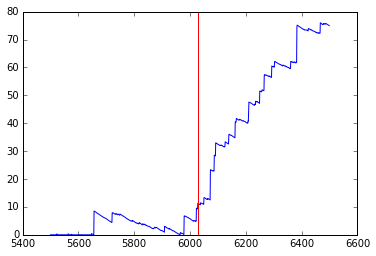

In [8]:
def smooth(data, alpha, threshold):
    value = 0
    filtered = 0
    for i, x in enumerate(data):
        value = value * alpha + (1 - alpha) * x
        if abs(value) < threshold:
            yield i, value
        else:
            filtered += 1
    print('%d values filtered out' % filtered)

S, S_idx, S_values = 0, list(), list()
critical, theta_1 = 20, -1
for i, x in smooth(data, alpha=0.05, threshold=0.55):
    S = max(0, S + numpy.log(g_pdf(x) / f_pdf(x)))
    S_values.append(S)
    S_idx.append(i)
    if S >= critical and theta_1 < 0:
        theta_1 = i
print('theta_1 = %d' % theta_1)

pyplot.plot(S_values)
pyplot.axvline(x=theta_1, color='r')
pyplot.show()

critical, theta_2 = 5, -1
for i, S in reversed(list(zip(S_idx, S_values))):
    if S < critical and theta_2 < 0:
        theta_2 = i + 1  # next value will be OK
print('theta_2 = %d' % theta_2)

pyplot.plot(range(5500, 6500), S_values[5500:6500])
pyplot.axvline(x=theta_2, color='r')
pyplot.show()

Тонким местом явно является подбор хорошего порогового значения для фильтрации выбивающихся значений - чтобы точно найти момент разладки хочется установить не слишком большой порог, в то время как одно большое значение первого распределения дают сразу весомый вклад в общую статистику. Однако, если идти с конца, то этой проблемы можно частично избежать.

Итоговое значения для второго набора данных: $\theta = 6029$.

## Часть 2. Анализ динамики курса валюта

Данные взяты с [сайта швейцарского национального банка](https://data.snb.ch/en/topics/ziredev#!/cube/devkuhistld)

В файле *currency.csv* данные об изменении курса португальского эскудо к швейцарскому франку с 1970 по 2001 год. Для начала распарсим файл и построим графики курса валюты и его изменения от измерения к измерению.

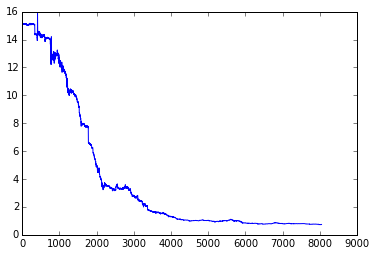

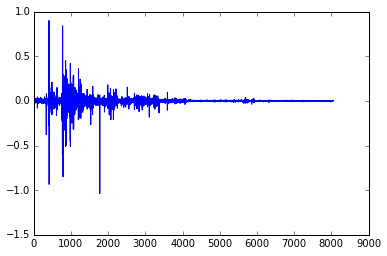

In [9]:
import csv

dates, raw_data, data = list(), list(), list()
prev = None
with open('currency.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=';', quotechar='"')
    for row in reader:
        if len(row) != 3 or row[1] != 'PPTE100' or not row[2]:
            continue
        value = float(row[2])
        dates.append(row[0])
        raw_data.append(value)
        if prev is not None:
            data.append(value - prev)
        prev = value

pyplot.plot(raw_data)
pyplot.show()
pyplot.plot(data)
pyplot.show()

Динамика курса выглядит неплохо: курс зашумленно-линейно убывает с 1970 по 1978 год, далее в некоторый момент все меняется и курс выходит на относительно стабильную отметку. Можно попробовать найти с помощью CUSUM тот момент, когда все пошло не так.

Анализировать будем дискретную производную процесса, чтобы понять, в какой момент сменился общий тренд. "Угадывать" распределения было решено по точкам с 1500 по 2500-ю и последним 2000, так как на первой тысяче точек наблюдается несколько значительных скачков курса и большая зашумленность.

-0.0063425 0.0465347068729
-4.8e-05 0.00236293588572


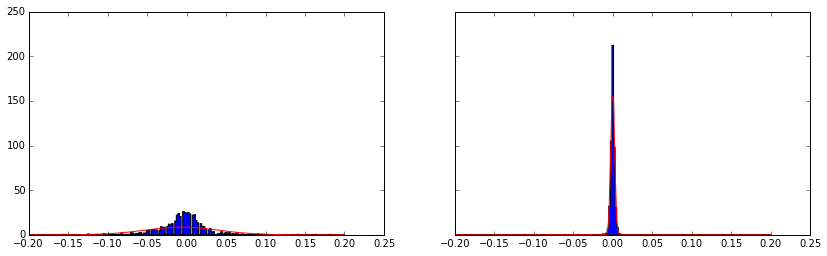

In [10]:
before, after = numpy.array(data[1500:2500]), numpy.array(data[-2000:])

a_1, b_1 = numpy.mean(before), numpy.std(before)
a_2, b_2 = numpy.mean(after), numpy.std(after)
print(a_1, b_1)
print(a_2, b_2)

fig, (ax1, ax2) = pyplot.subplots(1, 2, sharex=True, sharey=True)
fig.set_figwidth(14)
_, bins, _ = ax1.hist(before,
                      numpy.linspace(-0.2, 0.2, 200),
                      normed=1,
                      histtype='stepfilled')
ax1.plot(bins, mlab.normpdf(bins, a_1, b_1), color='r')

_, bins, _ = ax2.hist(after,
                      numpy.linspace(-0.2, 0.2, 200),
                      normed=1,
                      histtype='stepfilled')
ax2.plot(bins, mlab.normpdf(bins, a_2, b_2), color='r')
pyplot.show()

Распределения в целом напоминают нормальные, но кажется, что центральный пик у них выражен больше. Однако, попоробуем довести до конца эксперимент с нормальными распределениями.

0 values filtered out
theta = 3966
date: 1985-11-04


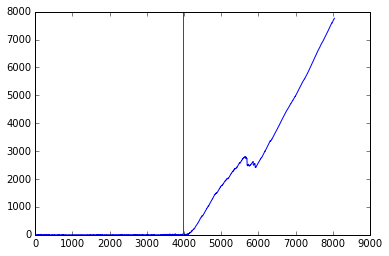

In [11]:
def log_pdf(x, a, b):
    return -numpy.log(b) - ((x - a) ** 2) / (2 * (b ** 2))
    
S, S_idx, S_values = 0, list(), list()
critical, theta = 30, -1
for i, x in smooth(data, alpha=0.05, threshold=1.0):
    S = max(0, S + log_pdf(x, a_2, b_2) - log_pdf(x, a_1, b_1))
    S_values.append(S)
    S_idx.append(i)
    if S >= critical and theta < 0:
        theta = i
print('theta = %d' % theta)
print('date: %s' % dates[theta])

pyplot.plot(S_values)
pyplot.axvline(x=theta, color='r')
pyplot.show()

CUSUM выдаёт момент разладки, после которого курс валюты относительно стабилизировался, что ж, выглядит правдоподобно. Так как в качестве периода для подбора параметров распределения были выбраны "средние" данные, то неудивительно, что CUSUM находит переход от режима убывания к режиму стабильности.

Если бы было больше измерений на промежуточном периоде стабильности, можно было бы попытаться отловить первый момент разладки.